<a href="https://colab.research.google.com/github/MGonzalez506/Dimensionamiento_PV/blob/15-obtener-la-mejor-ubicaci%C3%B3n-y-comparar-porcentualmente-el-rendimiento/Comparativa_de_simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simulación y Dimensionamiento

### Instalando las librerías de pvlib y rdtools

In [1]:
!pip install pvlib
!pip install rdtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 22.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 947 kB 5.2 MB/s 
     |████████████████████████████████| 192.9 MB 52 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Importar las librerías necesarias y algunos alias

In [2]:
#Imports
import sys
import os
import traceback
import time
import signal
import fcntl
import string
import re
import itertools

import math
import pytz
import pvlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from time import sleep
from datetime import datetime
from io import StringIO
from pvlib import solarposition
from pvlib import pvsystem
from pvlib import location
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import irradiance
from pvlib import temperature
from rdtools import get_clearsky_tamb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Datos del lugar en estudio y glosario

In [3]:
site_tz='America/Costa_Rica'
site_lat = 9.84950
site_lon = -83.91289
site_name = 'Moren Centro de acondicionamiento Físico'
site_alt = 1425

coordinates = [
               (site_lat,site_lon,site_name,site_alt,site_tz)
]

glosario = {
      'sapm':'Sandia PV Array Performance Model',
      'sam':'System Advisor Model',
      'tmy':'Typical Meteorological Year Data',
      'ghi':'Radiación global Horizontal', 
      'dni':'Radiación directa', 
      'dhi':'Radiación difusa', 
      'IR(h)':'Índice de claridad', 
      'aoi':'Ángulo de incidencia', 
      'dni_extra':'Porcentaje de radiación extra',
      'POA':'Plane of Array'
      }

### Seleccionar dataFrames, dispositivos y modelos
- Seleccionando el DataFrame a utilizar en cuanto a modelos e inversores
- Seleccionando el módulo fotovoltaico a utilizar y el inversor correspondiente
- Seleccionando el modelo de la temperatura a utilizar
- Seleccionando la cantidad de módulos que se necesitan para lograr lleva el inversor a utilizar su máxima potencia (string_config)
- Creando las dos listas que almacenarán los datos de la data típica por año y los meses seleccionados por la librería para el estudio

In [4]:
#Get modules & inverters
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = (sandia_modules['Canadian_Solar_CS5P_220M___2009_'])
#inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter = sapm_inverters['PV_Powered__PVP1100']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
string_config = 5

tmys = []
selected_months = []

### Generando una función que devuelve toda la data respecto a una ubicación u condiciones climatológicas específicas

In [5]:
def get_pvgis_tmy_from_coordinates(coordinates):
  tmys = []
  months = []
  for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    data_frame = pvlib.iotools.get_pvgis_tmy(latitude,longitude,map_variables=True)
    weather = data_frame[0]
    weather.index.name = 'utc_time'
    tmys.append(weather)
    months = data_frame[1]
  return tmys, months
tmys,selected_months = get_pvgis_tmy_from_coordinates(coordinates)

### Iteración sobre todos los ángulos de Azimuth seleccionados y ángulos de inclinación seleccionados también.

In [6]:
#Para realizar el cálculo del ángulo de inclinación óptima
system = {'module':module, 'inversor':inverter, 'surface_azimuth':180}
azimuth_testing = [0, 90,180,270]
tilt_testing = [5,10,15]
energies = {}
selected_azimuth_angle = 180
selected_tilt_angle = 10
selected_data = pd.DataFrame()
selected_data_annual_energy = {}
for tilt_angle in tilt_testing:
  for azimuth_angle in azimuth_testing:
    for weather in tmys:
        location = coordinates[0]
        latitude, longitude, name, altitude, timezone = location
        system['surface_tilt']=tilt_angle
        system['surface_azimuth']=azimuth_angle
        solpos = pvlib.solarposition.get_solarposition(
            time=weather.index,
            latitude=latitude,
            longitude=longitude,
            altitude=altitude,
            temperature=weather['temp_air'],
            pressure=pvlib.atmosphere.alt2pres(altitude)
        )
        dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass,pressure)
        aoi = pvlib.irradiance.aoi(
            system['surface_tilt'],
            system['surface_azimuth'],
            solpos['apparent_zenith'],
            solpos['azimuth']
        )
        #Irradiación total general
        total_irradiance = pvlib.irradiance.get_total_irradiance(
          system['surface_tilt'],
          system['surface_azimuth'],
          solpos['apparent_zenith'],
          solpos['azimuth'],
          weather['dni'],
          weather['ghi'],
          weather['dhi'],
          dni_extra=dni_extra,
          model='haydavies'
        )
        cell_temperature = pvlib.temperature.sapm_cell(
          total_irradiance['poa_global'],
          weather['temp_air'],
          weather['wind_speed'],
          **temperature_model_parameters     
        )
        #Irradiación efectiva
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
          total_irradiance['poa_direct'],
          total_irradiance['poa_diffuse'],
          am_abs,
          aoi,
          module
        )  
        dc=pvlib.pvsystem.sapm(effective_irradiance,cell_temperature,module)
        ac=pvlib.inverter.sandia(dc['v_mp']*string_config,dc['p_mp']*string_config,inverter)
        annual_energy = ac.sum()
        label = str(tilt_angle) + "º & " + str(azimuth_angle) + "Azi"
        energies[label] = annual_energy
        if selected_azimuth_angle == azimuth_angle and selected_tilt_angle == tilt_angle:
          selected_data = ac
          selected_data_annual_energy = annual_energy

### Gráfica de energía anual con múltiples combinaciones de ángulo de inclinación y ángulo de azimuth

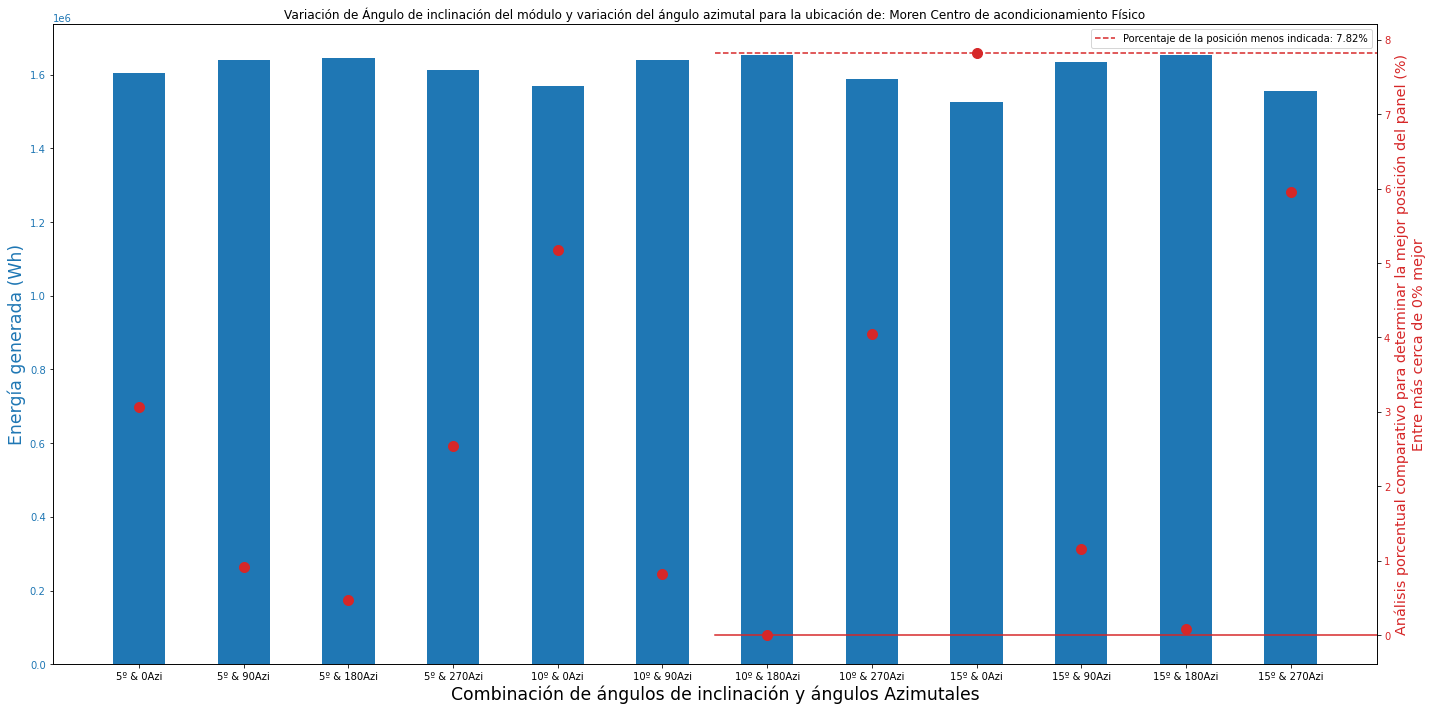

In [7]:
#Porcentualmente cuál es la mejor ubicación y en términos porcentuales por cuánto es mejor.
percentage_energy = []
energies = pd.Series(energies)
energy_max = energies.max()
for energy in energies:
  energy_percentage = 100-(energy*100/energy_max)
  percentage_energy.append(energy_percentage)
  #print('Energía máxima: ' + str(energy_max) + '. Energía del mes: ' + str(round(energy,4)) + ' Wh. ' + str(round(energy_percentage,3)) + '% menos del máximo')
percentage_energy = pd.Series(percentage_energy)
energy_labels = list(energies.keys())
energy_values = list(energies)
percentage_labels = list(percentage_energy.keys())
percentage_values = list(percentage_energy)

fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:blue'
ax1.title.set_text('Variación de Ángulo de inclinación del módulo y variación del ángulo azimutal para la ubicación de: ' + str(site_name))
ax1.set_xlabel('Combinación de ángulos de inclinación y ángulos Azimutales', fontsize='xx-large')
ax1.set_ylabel('Energía generada (Wh)', color=color, fontsize='xx-large')
ax1.bar(energy_labels, energy_values, color=color, width=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Análisis porcentual comparativo para determinar la mejor posición del panel (%)\nEntre más cerca de 0% mejor', color=color, fontsize='x-large')
ax2.axhline(y=0, color=color, linestyle='solid', xmin=0.5)
ax2.axhline(y=percentage_energy.max(), color=color, linestyle='dashed',label=('Porcentaje de la posición menos indicada: ' + str(round(percentage_energy.max(),2)) + '%'), xmin=0.5)
#ax2.plot(percentage_labels, percentage_values, linewidth=4, color=color)
ax2.scatter(percentage_labels, percentage_values, s=100, color=color)
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Producción mensual del arreglo para el ángulo de inclinación

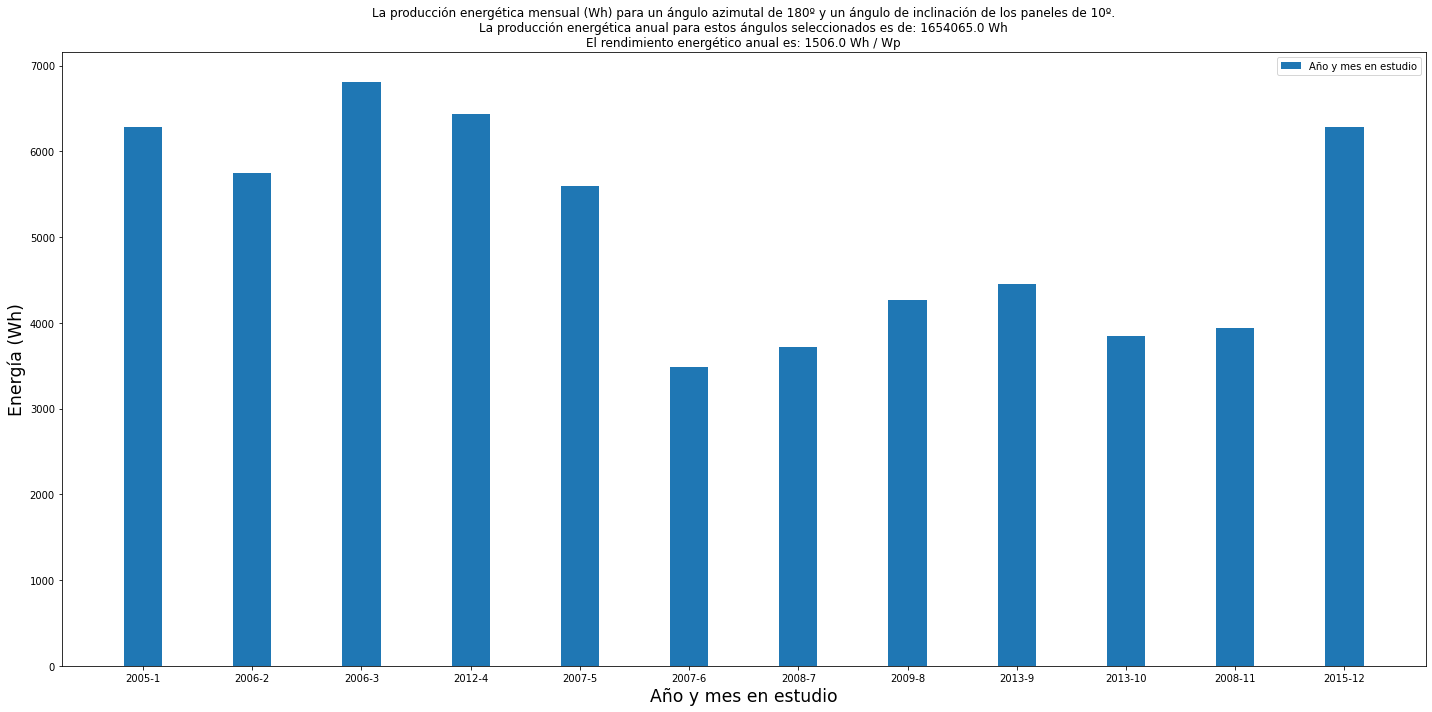

No handles with labels found to put in legend.


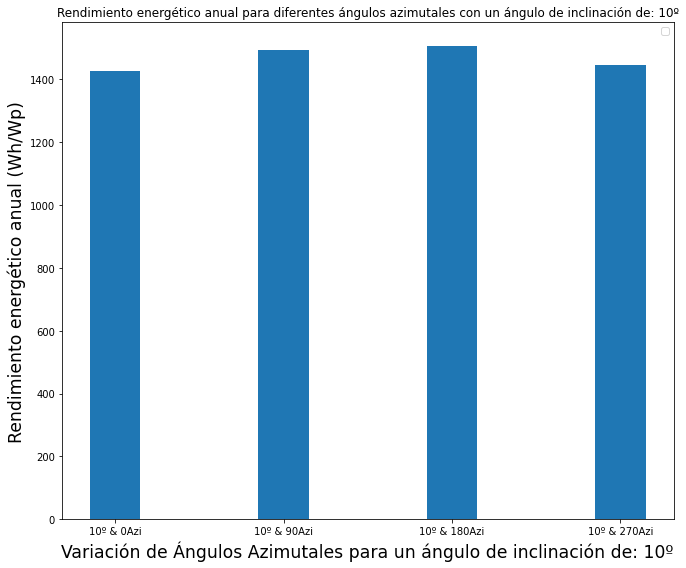

In [14]:
#print(last_ac.keys())
estudio_por_mes = {}
for i in selected_months:
  this_year = i['year']
  this_month = i['month']
  mes = str(this_year) + '-' + str(this_month) + '-01'
  x = selected_data.loc[mes:mes]
  sumatoria = x.sum()
  estudio_por_mes[mes[:-3]] = float(sumatoria)

potencia_maxima_del_panel = module['Impo'] * module['Vmpo'] * string_config
#for month_energy in estudio_por_mes: print(estudio_por_mes[month_energy]/potencia_maxima_del_panel)
estudio_por_mes = pd.Series(estudio_por_mes)
estudio_por_mes_labels = list(estudio_por_mes.keys())
estudio_por_mes_values = list(estudio_por_mes)
#print(selected_data_annual_energy)

labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic']
#labels = estudio_por_mes.keys()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(20,10))
rect1 = ax.bar(estudio_por_mes_labels, estudio_por_mes_values, width, label='Año y mes en estudio')

ax.set_xlabel('Año y mes en estudio', fontsize='xx-large')
ax.set_ylabel('Energía (Wh)', fontsize='xx-large')
ax.set_title('La producción energética mensual (Wh) para un ángulo azimutal de ' + str(selected_azimuth_angle) + 'º y un ángulo de inclinación de los paneles de ' + str(selected_tilt_angle) + 'º.\nLa producción energética anual para estos ángulos seleccionados es de: ' + str(selected_data_annual_energy.round(1)) + ' Wh\nEl rendimiento energético anual es: ' + str((selected_data_annual_energy/potencia_maxima_del_panel).round(1)) + ' Wh / Wp')
#ax.set_xticks(estudio_por_mes_values, estudio_por_mes_labels)
ax.legend()
#ax.bar_label(rect1, paadding=3)
fig.tight_layout()
plt.show()

lista_de_rendimientos = {}
lista_de_rendimientos['10º & 0Azi']=(energies['10º & 0Azi']/potencia_maxima_del_panel)
lista_de_rendimientos['10º & 90Azi']=(energies['10º & 90Azi']/potencia_maxima_del_panel)
lista_de_rendimientos['10º & 180Azi']=(energies['10º & 180Azi']/potencia_maxima_del_panel)
lista_de_rendimientos['10º & 270Azi']=(energies['10º & 270Azi']/potencia_maxima_del_panel)
lista_de_rendimientos = pd.Series(lista_de_rendimientos)
rendimientos_labels = list(lista_de_rendimientos.keys())
rendimientos_values = list(lista_de_rendimientos)

width = 0.3

fig, ax = plt.subplots(figsize=(10,8))
rect1 = ax.bar(rendimientos_labels, rendimientos_values, width)

ax.set_xlabel(('Variación de Ángulos Azimutales para un ángulo de inclinación de: ' + str(selected_tilt_angle) + 'º'), fontsize='xx-large')
ax.set_ylabel('Rendimiento energético anual (Wh/Wp)', fontsize='xx-large')
ax.set_title(('Rendimiento energético anual para diferentes ángulos azimutales con un ángulo de inclinación de: ' + str(selected_tilt_angle) + 'º'))
#ax.set_xticks(x, lista_de_angulos)
ax.legend()
#ax.bar_label(rect1, paadding=3)
fig.tight_layout()
plt.show()

### Gráfica que presenta el Mean Bias Error y el Root Median Square Error

No handles with labels found to put in legend.
No handles with labels found to put in legend.


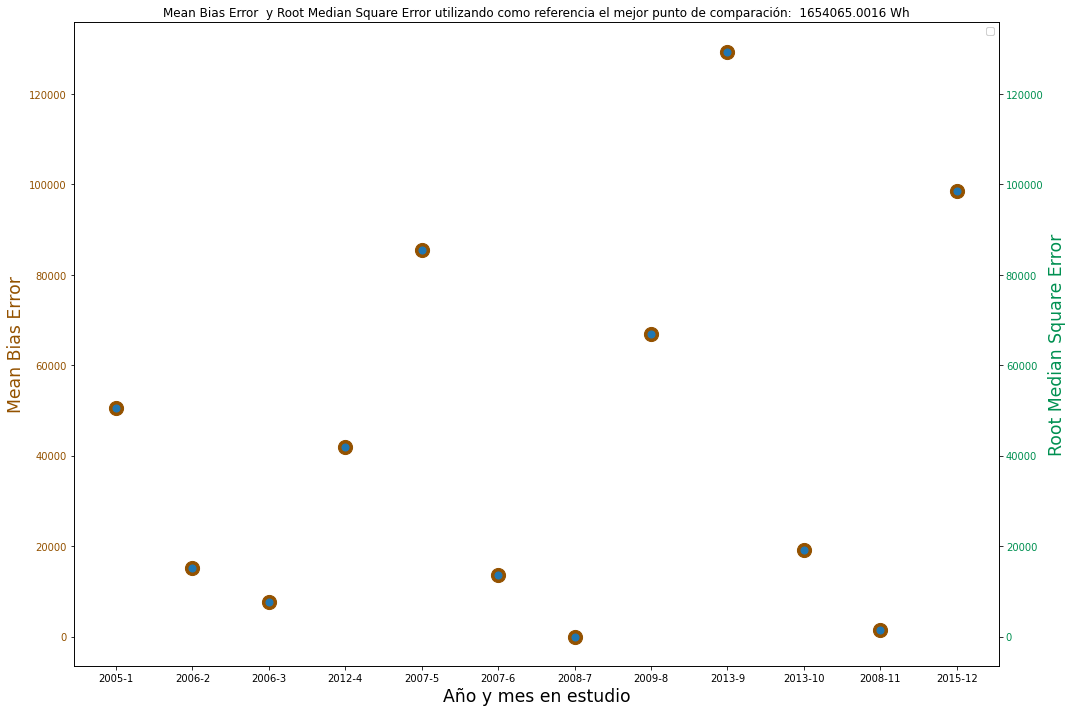

In [15]:
#Obtener el valor máximo de producción energética anual
energies = pd.Series(energies)
energy_max = energies.max()

#Calculando el Mean Bias Error absoluto
mean_bias_error = []
root_median_square_error = []
for energy in energy_values:
  mean_bias = energy_max-energy
  mean_bias_error.append(mean_bias)
  rmse = math.sqrt(mean_bias ** 2)
  root_median_square_error.append(rmse)

mean_bias_error = pd.Series(mean_bias_error)
root_median_square_error = pd.Series(root_median_square_error)

mean_bias_error_values = list(mean_bias_error)

fig, ax = plt.subplots(figsize=(15,10))

color = '#945200'
ax.title.set_text('Mean Bias Error  y Root Median Square Error utilizando como referencia el mejor punto de comparación:  ' + str(round(energy_max,4)) + ' Wh')
ax.set_xlabel('Año y mes en estudio', fontsize='xx-large')
ax.set_ylabel('Mean Bias Error', color=color, fontsize='xx-large')
ax.scatter(estudio_por_mes_labels, mean_bias_error_values, color=color, s=200)
ax.legend()
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()

#color = 'tab:cyan'
color = '#009051'
ax2.set_ylabel('Root Median Square Error', color=color, fontsize='xx-large')  # we already handled the x-label with ax1
ax2.scatter(estudio_por_mes_labels, root_median_square_error, s=50)
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()